##  TDM
__Nessa prática iremos transmitir via TDM, e recuperar 5 sinais__

Carregando bibliotecas, funções e o arquivos de dados:

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft,fftshift,ifft

# Como visto anteriormente, para economizar linhas de código, uma boa prática é resumir a conversão 
# binário/decimal em duas funções:
def de2bi(sinal):
    from numpy import fromiter,binary_repr,round 
    sinal_bin = round(sinal).astype(int)
    return fromiter(map(binary_repr,sinal_bin),dtype=int)
#
def bi2de(sinal):
    from numpy import ndarray
    sinal_dec = ndarray(len(sinal),dtype=int)
    for i in range(len(sinal_dec)):
        sinal_dec[i] = int(str(sinal[i]),2)  
    return sinal_dec
# Criação das funções, por questão de organização
def downsample(array,rate):
    return array[::rate]

def upsample(array,rate):
    from numpy import zeros
    ret =  zeros(rate*len(array))
    ret[::rate] = array 
    return ret
#


variaveis = loadmat('./Pacientes.mat')
Fs=float(variaveis['Fs'])
sinal_1 = variaveis['sinal_1'].flatten()
sinal_2 = variaveis['sinal_2'].flatten()
sinal_3 = variaveis['sinal_3'].flatten()
sinal_4 = variaveis['sinal_4'].flatten()
sinal_5 = variaveis['sinal_5'].flatten()

Concatenando os sinais em uma única matriz e realizando a amostragem temporal dos 5 sinais:

In [2]:
sinal=np.column_stack((sinal_1,sinal_2,sinal_3,sinal_4,sinal_5))
N_sinal=(len(sinal_1)) #tamanho de cada sinal
n_col=5
t=np.arange(0,N_sinal/Fs,1/Fs) #eixo temporal
N_samp=10
s_out=np.zeros((N_sinal,n_col))
s_out_aux=np.zeros(N_sinal)
for i in range(0,n_col):
    s_out_aux=downsample(sinal[:,i],N_samp)
    s_out[:,i]=upsample(s_out_aux,N_samp)

Agora, partimos para a etapa de quantização:

In [3]:
L=256 # níveis de quantização ( 8 bits)
q_out=np.zeros((N_sinal,n_col),dtype=np.uint64) #64 por comodidade, 8 seria suficiente
q_out_code=np.zeros((N_sinal,n_col),dtype=np.uint64)
sig_min=np.zeros(n_col)
sig_max=np.zeros(n_col)

for i in range(0,n_col):
    sig_max[i]=max(s_out[:,i])
    sig_min[i]=min(s_out[:,i])
    Delta=(sig_max[i]-sig_min[i])/L                       # Intervalo de quantização (distância entre um nível e outro)
    q_level=np.arange(sig_min[i]+Delta/2,sig_max[i],Delta) # Vetor com as amplitudes dos Q níveis (Ex: nível 4 -- q_level(4)= -0.05V)
    sigp=s_out[:,i]-sig_min[i]                                 # Deixa o sinal somente com amplitudes positivas (shift para cima)
    # Calcula a quantidade de nívels (não inteiro ainda) de cada amostra (elementos >= 0)
    sigp=sigp*(1/Delta)                                
    sigp=sigp + 1/2 +0.0001                          # Tira elementos do zero 
    # Agora que nenhum valor do sinal  é zero nem negativo:
    qindex=np.round(sigp)                            # Encontra inteiro mais proximo para cada elemento
    qindex[qindex>L] = L-1                           # Trunca o excedente de qindex 
    qindex = qindex.astype(int)                      # Casting para inteiro (garantindo que é do tipo inteiro)
    q_out[:,i] = qindex                              #Apenas os níveis inteiros: 0 a 255 
    q_out_code[:,i]= de2bi(qindex)                   # Transforma em sinal binário 

Com o sinal amostrado, quantizado e codificado, partimos para a multiplexação TDM:

In [5]:
frameSize = 5;                            # Tamanho do quadro (número máximo de sinais a serem multiplexados)      
mux_sig = np.zeros(len(q_out_code[:,0])*frameSize,dtype=int)
for i in range(1,len(q_out_code[:,0])+1): 
    mux_sig[5*(i-1)]      =   q_out_code[i-1,0]  # Indexação em python começa em 0
    mux_sig[5*(i-1)+1]    =   q_out_code[i-1,1]
    mux_sig[5*(i-1)+2]    =   q_out_code[i-1,2]
    mux_sig[5*(i-1)+3]    =   q_out_code[i-1,3]
    mux_sig[5*(i-1)+4]    =   q_out_code[i-1,4]

Os sinais estão multiplexados, agora vamos demultiplexá-los (RECEPTOR)

In [6]:
demux_01 = np.zeros(N_sinal,dtype=int)
demux_02 = np.zeros(N_sinal,dtype=int)
demux_03 = np.zeros(N_sinal,dtype=int)
demux_04 = np.zeros(N_sinal,dtype=int)
demux_05 = np.zeros(N_sinal,dtype=int)
for i in range(1,N_sinal+1):
    demux_01[i-1]= mux_sig[(i-1)*5 ]
    demux_02[i-1]= mux_sig[(i-1)*5 + 1]
    demux_03[i-1]= mux_sig[(i-1)*5 + 2]
    demux_04[i-1]= mux_sig[(i-1)*5 + 3]
    demux_05[i-1]= mux_sig[(i-1)*5 + 4]

Os sinais ainda estão em binário, vamos agora decodificá-los de binário para inteiro, retirar o offset gerado pela quantização e finalmente converter o inteiro para o equivalente em float (tensão do sinal, assumindo que o receptor saiba o valor máximo de tensão dos sinais originais):

In [7]:
sig_rec01 = (bi2de(demux_01)-127)*sig_max[0]*256
sig_rec02 = (bi2de(demux_02)-127)*sig_max[1]*256
sig_rec03 = (bi2de(demux_03)-127)*sig_max[2]*256
sig_rec04 = (bi2de(demux_04)-127)*sig_max[3]*256
sig_rec05 = (bi2de(demux_05)-127)*sig_max[4]*256

Os sinais ainda estão "digitais (amostrados)". Para recuperalos em sua "forma analógica" recorremos à reconstrução ideal do sinal por meio da filtragem em frequência. Para isso, realizamos a FFT de cada sinal recuperado no demux, realizamos a filtragem na frequencia (multiplicação do sinal pela rect com banda suficiente para os sinais) e finalmente, a transformada inversa para obetemos o sinal no domínio do tempo:

In [10]:
##Recuperaçao IDEAL VIA FILTRAGEM NA FREQUENCIA 
lfft=len(sig_rec01)
BW=550#banda da rect (em pontos da fft)
freq = np.arange(-Fs/2,Fs/2,Fs/lfft)
S1_out=fftshift(fft(sig_rec01,lfft)/lfft)
S2_out=fftshift(fft(sig_rec02,lfft)/lfft)
S3_out=fftshift(fft(sig_rec03,lfft)/lfft)
S4_out=fftshift(fft(sig_rec04,lfft)/lfft)
S5_out=fftshift(fft(sig_rec05,lfft)/lfft)

#plt.figure(2)
#plt.plot(freq,np.abs(S1_out))
#plt.show()
H_lpf=np.zeros(lfft)                                         # Zera vetor filtro
H_lpf[lfft//2-BW:lfft//2+BW-1]=1                             # Define 1 na frequência desejada
Q1_recv=N_samp*S1_out*H_lpf                                # Filtragem ideal
Q2_recv=N_samp*S2_out*H_lpf   
Q3_recv=N_samp*S3_out*H_lpf   
Q4_recv=N_samp*S4_out*H_lpf   
Q5_recv=N_samp*S5_out*H_lpf   

q1_recv=np.real(ifft(fftshift(Q1_recv))) 
q2_recv=np.real(ifft(fftshift(Q2_recv)))                      # Reconstroi o sinal no tempo
q3_recv=np.real(ifft(fftshift(Q3_recv)))
q4_recv=np.real(ifft(fftshift(Q4_recv)))
q5_recv=np.real(ifft(fftshift(Q5_recv)))

Finalmente, a plotagem comparativa entre os sinais originais e os recuperados no demux TDM  e regenerados:

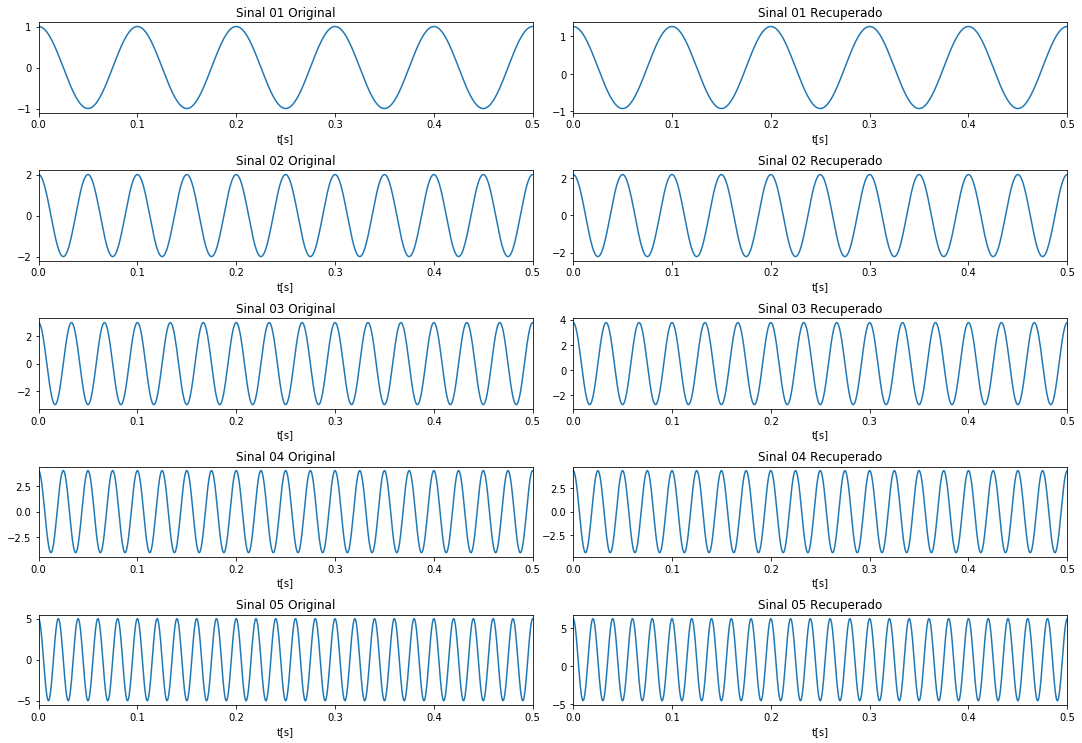

In [19]:
#Plotagens:
plt.figure(1,figsize=(15,10))
plt.subplot(521)
plt.plot(t,sinal_1)
plt.title("Sinal 01 Original")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])
plt.tight_layout()
plt.subplot(522)
plt.plot(t,q1_recv)
plt.title("Sinal 01 Recuperado")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])
plt.tight_layout()

plt.subplot(523)
plt.plot(t,sinal_2)
plt.title("Sinal 02 Original")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])
plt.tight_layout()
plt.subplot(524)
plt.plot(t,q2_recv)
plt.title("Sinal 02 Recuperado")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])
plt.tight_layout()

plt.subplot(525)
plt.plot(t,sinal_3)
plt.title("Sinal 03 Original")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])
plt.subplot(526)
plt.plot(t,q3_recv)
plt.title("Sinal 03 Recuperado")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])

plt.subplot(527)
plt.plot(t,sinal_4)
plt.title("Sinal 04 Original")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])
plt.subplot(528)
plt.plot(t,q4_recv)
plt.title("Sinal 04 Recuperado")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])

plt.subplot(529)
plt.plot(t,sinal_5)
plt.title("Sinal 05 Original")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])
plt.subplot(5,2,10)
plt.plot(t,q5_recv)
plt.title("Sinal 05 Recuperado")
plt.xlabel("t[s]")
plt.xlim([0, 0.5])
plt.show()

